# Regression Coefficients - Revisited

## Lesson Objectives

By the end of this lesson, students will be able to:
- Use scikit-learn v1.1's simplified toolkit.
- Extract and visualize coefficients from sklearn regression model. 
- Control panda's display options to facilitate interpretation.


## Introduction

- At the end of last stack, we dove deep into linear regression models and their assumptions. We introduced a new package called statsmodels, which produced a Linear Regression model using "Ordinary-Least-Squared (OLS)". 
- The model included a robust statistical summary that was incredibly informative as we critically diagnosed our regression model and if we met the assumptions of linear regression.
- This stack, we will be focusing on extracting insights from our models: both by examining parameters/aspects of the model itself, like the coefficients it calculated, but also by applying some additional tools and packages specifically designed to explain models. 

- Most of these tools are compatible with the scikit-learn ecosystem but are not yet available for statsmodels.

Since we are not focusing on regression diagnostics this week, we will shift back to using scikit-learn models. Scikit-learn recently released version 1.1.1, which added several helpful tools that will simplify our workflow. 

Let's review some of these key updates as we rebuild our housing regression model from week 16.


# Confirming Package Versions

- All packages have a version number that indicates which iteration of the package is currently being used.
    - If you import an entire package, you can use the special method `package.__version__` (replace package with the name of the package you want to check).
- The reason this is important is that as of the writing of this stack, Google Colab is still using a version of python that is too old to support the newest scikit-learn.
    - You can check which version of python you are using by running the following command in a jupyter notebook:
        - `!python --version`
        - Note: if you remove the `!`, you can run this command in your terminal.

- If you run the following code on Google Colab and on your local computer, you can compare the version numbers. 
        
<img src="colab_versions.png" width=400px>

- Now, run the following block of code in a jupyter notebook on your local machine to confirm that you have Python 3.8.13 and sklearn v1.1.1.


In [1]:
# Run the following command on your local computer to 
import sklearn
print(f"sklearn version: {sklearn.__version__}")
!python --version

sklearn version: 1.1.1
Python 3.8.13



>- If you have a Python 3.7 or an earlier version of scikit-learn, please revisit the "`<Insert the name of the "week" of content on the LP for installation>`". 
    - See the "`Updating Your Dojo-Env Lesson` [Note to Brenda: does not exist yet - see 1:1 doc for question on handling multiple envs] for how to remove your current dojo-env and replace it with the new one.

# Extracting Coefficients from LinearRegression in scikit-learn

## Highlighted Changes  - scikit-learn v1.1

- The single biggest change in the updated sklearn is a fully-functional `.get_feature_names_out()` method in the `ColumnTransformer`.
    - This will make it MUCH easier for us to extract our transformed data as dataframes and to match up the feature names to our models' coefficients.
- There are some additional updates that are not pertinent to this stack, but if you are curious, you can find the [details on the new release here](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_1_0.html).

## New and Improved `ColumnTransformer` 

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Customization Options
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

# set random seed
SEED = 321
np.random.seed(SEED)

## set text displays for sklearn
from sklearn import set_config
set_config(display='text')

In [3]:
## Load in the student performance - math dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-mat')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    float64
 3   address     395 non-null    object 
 4   famsize     395 non-null    object 
 5   Pstatus     395 non-null    object 
 6   Medu        395 non-null    float64
 7   Fedu        395 non-null    float64
 8   Mjob        395 non-null    object 
 9   Fjob        395 non-null    object 
 10  reason      395 non-null    object 
 11  guardian    395 non-null    object 
 12  traveltime  395 non-null    float64
 13  studytime   395 non-null    float64
 14  failures    395 non-null    float64
 15  schoolsup   395 non-null    object 
 16  famsup      395 non-null    object 
 17  paid        395 non-null    object 
 18  activities  395 non-null    object 
 19  nursery     395 non-null    o

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,...,4.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6.0,6.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5.0,6.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,4.0,3.0,2.0,2.0,3.0,3.0,10.0,7.0,8.0,10.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14.0,15.0
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,...,4.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10.0,10.0


In [4]:
df.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64

### Selecting Our Features

- If we wanted to make recommendations to the school district on how to identify and help students that will perform poorly by year 3, we should think about what features make the most sense to include.

- There are ~2 different approaches  we could take to what to include, depending on what use case we are addressing for our stakeholder.

For example, if our primary goal is to just identify 3rd year students that will perform poorly, then including all of these features would make sense.

However, if our primary goal is to identify which INCOMING students will perform poorly by their 3rd year, then we would NOT include G1 or G2, since the school will not have those grades for bran new incoming students.

- We will start our analysis addressing the first use case, identify rising 3rd year students that will perform poorly.

### Train Test Split

In [5]:
## Make x and y variables
y = df['G3'].copy()
X = df.drop(columns=['G3']).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
215,GP,F,17.0,U,LE3,T,3.0,2.0,other,other,...,no,4.0,4.0,4.0,1.0,3.0,1.0,2.0,14.0,15.0
48,GP,M,15.0,U,GT3,T,4.0,2.0,teacher,other,...,no,4.0,3.0,3.0,2.0,2.0,5.0,2.0,15.0,15.0
303,GP,F,17.0,U,GT3,T,3.0,2.0,health,health,...,no,5.0,2.0,2.0,1.0,2.0,5.0,0.0,17.0,17.0
160,GP,M,17.0,R,LE3,T,2.0,1.0,at_home,other,...,yes,3.0,3.0,2.0,2.0,2.0,5.0,0.0,7.0,6.0
60,GP,F,16.0,R,GT3,T,4.0,4.0,health,teacher,...,no,2.0,4.0,4.0,2.0,3.0,4.0,6.0,10.0,11.0


### Preprocessing + ColumnTransformer

In [6]:
## make categorical selector and verifying it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [7]:
## make numeric selector and verifying it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2']

In [8]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

> Nothing we have done yet should be new code. The changes we will make will be when we create our ColumnTransformer with `make_column_transformer`.
- From now on, you should add `verbose_feature_names_out=False` to `make_column_transformer`

In [9]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1410e5160>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1410e54f0>)],
                  verbose_feature_names_out=False)

>- In order to extract the feature names from the preprocessor, we first have to fit it on the data.
- Next, we can use the `preprocessor.get_feature_names_out()` method and save the output as something like "feature_names" or "final_features".

In [10]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'school_GP', 'school_MS', 'sex_F', 'sex_M',
       'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3',
       'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_father', 'guardian_mother',
       'guardian_other', 'schoolsup_no', 'schoolsup_yes', 'famsup_no',
       'famsup_yes', 'paid_no', 'paid_yes', 'activities_no',
       'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no',
       'higher_yes', 'internet_no', 'internet_yes', 'romantic_no',
       'romantic_yes'], dtype=object)

- Notice how we were able to get the complete list of feature names, including the One Hot Encoded features with their proper "zipcode" prefix. 
- Quick note: if you forgot to add `verbose_feature_names_out` when you made your preprocessor, you would get something like this:


In [11]:
## make the preprocessing column transformer
preprocessor_oops = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel)
                                           ) # forgot verbose_feature_names_out=False
## fit column transformer and run get_feature_names_out
preprocessor_oops.fit(X_train)
feature_names_oops = preprocessor_oops.get_feature_names_out()
feature_names_oops

array(['pipeline-1__age', 'pipeline-1__Medu', 'pipeline-1__Fedu',
       'pipeline-1__traveltime', 'pipeline-1__studytime',
       'pipeline-1__failures', 'pipeline-1__famrel',
       'pipeline-1__freetime', 'pipeline-1__goout', 'pipeline-1__Dalc',
       'pipeline-1__Walc', 'pipeline-1__health', 'pipeline-1__absences',
       'pipeline-1__G1', 'pipeline-1__G2', 'pipeline-2__school_GP',
       'pipeline-2__school_MS', 'pipeline-2__sex_F', 'pipeline-2__sex_M',
       'pipeline-2__address_R', 'pipeline-2__address_U',
       'pipeline-2__famsize_GT3', 'pipeline-2__famsize_LE3',
       'pipeline-2__Pstatus_A', 'pipeline-2__Pstatus_T',
       'pipeline-2__Mjob_at_home', 'pipeline-2__Mjob_health',
       'pipeline-2__Mjob_other', 'pipeline-2__Mjob_services',
       'pipeline-2__Mjob_teacher', 'pipeline-2__Fjob_at_home',
       'pipeline-2__Fjob_health', 'pipeline-2__Fjob_other',
       'pipeline-2__Fjob_services', 'pipeline-2__Fjob_teacher',
       'pipeline-2__reason_course', 'pipeline-2__r

### Remaking Our X_train and X_test as DataFrames

- Now that we have our list of feature names, we can very easily transform out X_train and X_test into preprocessed dataframes. 
- We can immediately turn the output of our preprocessor into a dataframe and do not need to save it as a separate variable first.
    - Therefore, in our pd.DataFrame, we will provide the `preprocessor.transform(X_train)` as the first argument, followed by `columns=feature_names` (the list we extracted from our precprocessor)
    - Pro Tip: you can also use the same index as your X_train or X_test variable, if you want to match up one of the transformed rows with the original dataframe.

In [12]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_train_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
215,17.0,3.0,2.0,2.0,2.0,0.0,4.0,4.0,4.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
48,15.0,4.0,2.0,1.0,2.0,0.0,4.0,3.0,3.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
303,17.0,3.0,2.0,1.0,4.0,0.0,5.0,2.0,2.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [13]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
58,15.0,1.0,2.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
338,18.0,3.0,3.0,1.0,4.0,0.0,5.0,3.0,3.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
291,17.0,4.0,3.0,1.0,3.0,0.0,4.0,2.0,2.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [14]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

58      9.0
338    17.0
291    15.0
Name: G3, dtype: float64

- Notice that we cannot see all of our features after OneHotEncoding. Pandas truncates the display in the middle and displays `...` instead. 
- We can get around this by changing the settings in Pandas using `pd.set_option`
    - In this case, we want to change the `max_columns` to be a number larger than our number of final features. Since we have 87 features, setting the `max_columns` to 100 would be sufficient.
- For more information on pandas options, see their [documentation on Options and Settings](https://pandas.pydata.org/docs/user_guide/options.html)
- Final note: in your project notebooks, you should add this function to the top of your notebook right after your imports.

In [15]:
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',100)
X_train_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
215,17.0,3.0,2.0,2.0,2.0,0.0,4.0,4.0,4.0,1.0,3.0,1.0,2.0,14.0,15.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
48,15.0,4.0,2.0,1.0,2.0,0.0,4.0,3.0,3.0,2.0,2.0,5.0,2.0,15.0,15.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
303,17.0,3.0,2.0,1.0,4.0,0.0,5.0,2.0,2.0,1.0,2.0,5.0,0.0,17.0,17.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


## Extracting Coefficients and Intercept from Scikit-Learn Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
print(f'Training R^2: {lin_reg.score(X_train_df, y_train):.3f}')
print(f'Test R^2: {lin_reg.score(X_test_df, y_test):.3f}')

Training R^2: 0.848
Test R^2: 0.807


In [17]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def evaluate_linreg(model, X_train,y_train, X_test,y_test, return_df=False):

    results = []
    
    y_hat_train = model.predict(X_train)
    r2_train = r2_score(y_train,y_hat_train)
    rmse_train = mean_squared_error(y_train,y_hat_train, squared=False)
    results.append({'Data':'Train', 'R^2':r2_train, "RMSE": rmse_train})
    
    y_hat_test = model.predict(X_test)
    r2_test = r2_score(y_test,y_hat_test)
    rmse_test = mean_squared_error(y_test,y_hat_test, squared=False)
    results.append({'Data':'Test', 'R^2':r2_test, "RMSE": rmse_test})
    
    results_df = pd.DataFrame(results).round(3).set_index('Data')
    results_df.loc['Delta'] = results_df.loc['Test'] - results_df.loc['Train']
    results_df = results_df.T
    
    if return_df:
        return results_df
    else:
        print(results_df)

In [18]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_linreg(lin_reg, X_train_df, y_train, X_test_df,y_test)

Data  Train   Test  Delta
R^2   0.848  0.807 -0.041
RMSE  1.830  1.848  0.018


- For scikit-learn Linear Regressions, we can find the coefficients for the features that were included in our X-data under the `.coef_` attribute. 
-  the `.coef_` is a numpy matrix that should have the same number of values as the # of columns in X_train_df

In [19]:
lin_reg.coef_

array([-2.20466758e-01,  2.91333976e-01, -1.77473599e-01,  1.87333785e-01,
       -2.15619658e-01, -1.00533554e-01,  3.09222203e-01,  1.89125262e-02,
       -1.52832343e-02, -2.12300255e-01,  2.60933091e-01,  2.48701789e-02,
        5.32226669e-02,  1.40936178e-01,  9.91331303e-01, -1.26407646e+12,
       -1.26407646e+12,  5.40388537e+11,  5.40388537e+11, -1.18047850e+11,
       -1.18047850e+11,  3.46283602e+11,  3.46283602e+11, -5.19732724e+11,
       -5.19732724e+11, -5.53239828e+11, -5.53239828e+11, -5.53239828e+11,
       -5.53239828e+11, -5.53239828e+11,  2.08905427e+11,  2.08905427e+11,
        2.08905427e+11,  2.08905427e+11,  2.08905427e+11, -1.26006863e+11,
       -1.26006863e+11, -1.26006863e+11, -1.26006863e+11,  4.11586427e+11,
        4.11586427e+11,  4.11586427e+11, -3.64876692e+11, -3.64876692e+11,
       -5.31822663e+11, -5.31822663e+11, -1.89883820e+11, -1.89883820e+11,
       -1.85190300e+11, -1.85190300e+11,  3.62281762e+11,  3.62281762e+11,
        2.51568399e+11,  

In [20]:
## Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

58


58

> Note: if for some reason the length of your coef_ is 1, you should add the `.flatten()` method to convert the  coef_ into a simple 1-D array.

### Saving the coefficients as a pandas Series

- We can immediately turn the the models' .coef_ into a pd.Series, as well.
    - Therefore, in our pd.Series, we will provide the `lin_reg.coef_` as the first argument, followed by `index=feature_names` (pandas Series are 1D and do not have columns)

In [22]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs

age                 -2.204668e-01
Medu                 2.913340e-01
Fedu                -1.774736e-01
traveltime           1.873338e-01
studytime           -2.156197e-01
failures            -1.005336e-01
famrel               3.092222e-01
freetime             1.891253e-02
goout               -1.528323e-02
Dalc                -2.123003e-01
Walc                 2.609331e-01
health               2.487018e-02
absences             5.322267e-02
G1                   1.409362e-01
G2                   9.913313e-01
school_GP           -1.264076e+12
school_MS           -1.264076e+12
sex_F                5.403885e+11
sex_M                5.403885e+11
address_R           -1.180478e+11
address_U           -1.180478e+11
famsize_GT3          3.462836e+11
famsize_LE3          3.462836e+11
Pstatus_A           -5.197327e+11
Pstatus_T           -5.197327e+11
Mjob_at_home        -5.532398e+11
Mjob_health         -5.532398e+11
Mjob_other          -5.532398e+11
Mjob_services       -5.532398e+11
Mjob_teacher  

- The constant/intercept is not included in the .ceof_ attribute (if we used the default settings for LinearRegression which sets fit_intercept = True)
- The intercept is stored in the `.intercept_` attribute 
- We can add this as a new value to our coeffs series.
- Note: it is up to you what you name your intercept/constant. If you wanted to keep the naming convention of statsmodels, you could use "const" or just "intercept" for simplicity.

In [23]:
# use .loc to add the intercept to the series
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

age                 -2.204668e-01
Medu                 2.913340e-01
Fedu                -1.774736e-01
traveltime           1.873338e-01
studytime           -2.156197e-01
failures            -1.005336e-01
famrel               3.092222e-01
freetime             1.891253e-02
goout               -1.528323e-02
Dalc                -2.123003e-01
Walc                 2.609331e-01
health               2.487018e-02
absences             5.322267e-02
G1                   1.409362e-01
G2                   9.913313e-01
school_GP           -1.264076e+12
school_MS           -1.264076e+12
sex_F                5.403885e+11
sex_M                5.403885e+11
address_R           -1.180478e+11
address_U           -1.180478e+11
famsize_GT3          3.462836e+11
famsize_LE3          3.462836e+11
Pstatus_A           -5.197327e+11
Pstatus_T           -5.197327e+11
Mjob_at_home        -5.532398e+11
Mjob_health         -5.532398e+11
Mjob_other          -5.532398e+11
Mjob_services       -5.532398e+11
Mjob_teacher  

### Displaying the Coefficients

- Just like we increased the number of columns displayed by pandas, we can also increase the number of rows displayed by pandas.
- CAUTION: DO NOT SET THE MAX ROWS TO 0!! If you try to display a dataframe that has 1,000,000 it will try to display ALL 1,000,000 rows and will crash your kernel.

In [24]:
# pd.set_option('display.max_rows',100)
coeffs

age                 -2.204668e-01
Medu                 2.913340e-01
Fedu                -1.774736e-01
traveltime           1.873338e-01
studytime           -2.156197e-01
failures            -1.005336e-01
famrel               3.092222e-01
freetime             1.891253e-02
goout               -1.528323e-02
Dalc                -2.123003e-01
Walc                 2.609331e-01
health               2.487018e-02
absences             5.322267e-02
G1                   1.409362e-01
G2                   9.913313e-01
school_GP           -1.264076e+12
school_MS           -1.264076e+12
sex_F                5.403885e+11
sex_M                5.403885e+11
address_R           -1.180478e+11
address_U           -1.180478e+11
famsize_GT3          3.462836e+11
famsize_LE3          3.462836e+11
Pstatus_A           -5.197327e+11
Pstatus_T           -5.197327e+11
Mjob_at_home        -5.532398e+11
Mjob_health         -5.532398e+11
Mjob_other          -5.532398e+11
Mjob_services       -5.532398e+11
Mjob_teacher  

### Suppressing Scientific Notation in Pandas

> We can ALSO use panda's options to change how it display numeric values.
- if we want to add a `,` separator for thousands and round to 2 decimal places, we would use the format code ",.2f". 
- In order for Pandas to use this, we will have to use an f-string with a lambda x. (X represent any numeric value being displayed by pandas).

In [25]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

age                                 -0.22
Medu                                 0.29
Fedu                                -0.18
traveltime                           0.19
studytime                           -0.22
failures                            -0.10
famrel                               0.31
freetime                             0.02
goout                               -0.02
Dalc                                -0.21
Walc                                 0.26
health                               0.02
absences                             0.05
G1                                   0.14
G2                                   0.99
school_GP           -1,264,076,458,474.35
school_MS           -1,264,076,458,473.97
sex_F                  540,388,537,093.94
sex_M                  540,388,537,093.93
address_R             -118,047,849,812.08
address_U             -118,047,849,811.93
famsize_GT3            346,283,601,785.27
famsize_LE3            346,283,601,785.28
Pstatus_A             -519,732,724

## Inspecting Our Coefficients - Sanity Check

- Hmmmm....hold on now. We saw last lesson that our target, G3, contained scores from 0 to 20. 
- So HOW IN THE WORLD does it make sense that your model's baseline value (the y-intercept) is 2 trillion?!?
- This may be due to us introducing multicollinearity during One Hot Encoding.

#### Using OneHotEncoder with binary categorical features.

- if we check just our string columns for the # of unique values:

In [26]:
df.select_dtypes('object').nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

- We can see that many of our categories only have 2 options.
    - For example: the paid feature.
        - One Hot Encoding this feature will create a "paid_no" column and "paid_yes" column.

- Here is where we should think about our final use case for this data. If we want to explain student performance, there is no benefit to one-hot-encoding both categories. 
    - We know that if someone has a 0 for "paid_yes" that it means "paid_no" would be 1. 
    
    
- To remove these unnecessary columns, we can change our arguments for our OneHotEncoder in our pipeline and add "`drop='if_binary'.
    - HOWEVER, we cannot use BOTH `handle_unknown` AND the `drop` argument together. We will get an error message.

- Since our current modeling will be used to extract insights for our stakeholder and will not be deployed to the cloud where it will run predictions on new data, we can safely switch to using the drop='if_binary' option.

## Recreating Our X/y data with `drop='if_binary'`

In [27]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
58,15.00,1.00,2.00,1.00,2.00,0.00,4.00,3.00,2.00,1.00,1.00,5.00,2.00,9.00,10.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00
338,18.00,3.00,3.00,1.00,4.00,0.00,5.00,3.00,3.00,1.00,1.00,1.00,7.00,16.00,15.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00
291,17.00,4.00,3.00,1.00,3.00,0.00,4.00,2.00,2.00,1.00,2.00,3.00,0.00,15.00,15.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00


- As we can see above, we now only have 1 version of our binary columns (e.g. "paid_yes","internet_yes")

## Refitting a LinearRegression

In [28]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_linreg(lin_reg, X_train_df, y_train, X_test_df,y_test)

Data  Train  Test  Delta
R^2    0.85  0.81  -0.04
RMSE   1.83  1.85   0.02


In [29]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs['intercept'] = lin_reg.intercept_
coeffs

age                 -0.22
Medu                 0.29
Fedu                -0.18
traveltime           0.19
studytime           -0.22
failures            -0.10
famrel               0.31
freetime             0.02
goout               -0.02
Dalc                -0.21
Walc                 0.26
health               0.03
absences             0.05
G1                   0.14
G2                   0.99
school_MS            0.38
sex_M               -0.01
address_U            0.15
famsize_LE3          0.01
Pstatus_T            0.38
Mjob_at_home        -0.05
Mjob_health         -0.02
Mjob_other           0.16
Mjob_services        0.12
Mjob_teacher        -0.21
Fjob_at_home         0.33
Fjob_health          0.38
Fjob_other          -0.11
Fjob_services       -0.54
Fjob_teacher        -0.05
reason_course       -0.09
reason_home         -0.42
reason_other         0.30
reason_reputation    0.21
guardian_father     -0.20
guardian_mother      0.07
guardian_other       0.13
schoolsup_yes        0.34
famsup_yes  

- OK, now THESE coefficients pass our sanity check. They are all values <1, which seems appropriate for predicting a value between 0 and 100.

### VIsualizing Coefficients

- Now, let's examine the coefficients below and see if they make sense, based on our knowledge about houses. 



- To more easily analyze our coefficients, we will sort them by value and plot them as a horizontal bar graph.
- Let's also load in the data dictionary so we can make informed interpretations about the meaning of our features

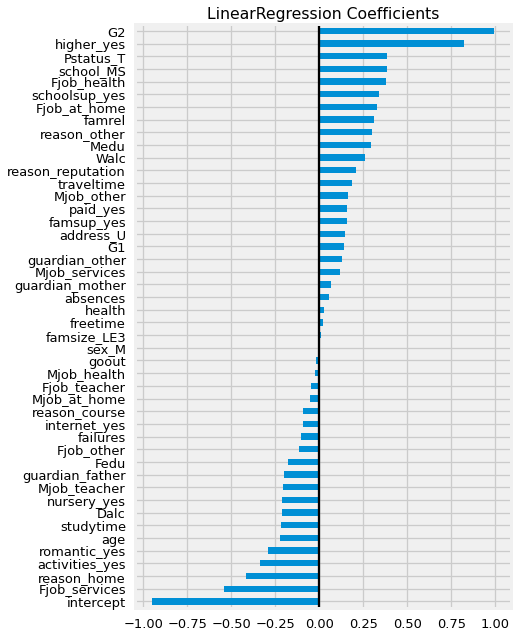

In [30]:
## Plot the coefficients
ax = coeffs.sort_values().plot(kind='barh',figsize=(6,10))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

- **Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:**
- 1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
- 2 sex - student's sex (binary: "F" - female or "M" - male)
- 3 age - student's age (numeric: from 15 to 22)
- 4 address - student's home address type (binary: "U" - urban or "R" - rural)
- 5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
- 6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
- 7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- 8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- 9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- 10 Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- 11 reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
- 12 guardian - student's guardian (nominal: "mother", "father" or "other")
- 13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
- 14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- 15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)
- 16 schoolsup - extra educational support (binary: yes or no)
- 17 famsup - family educational support (binary: yes or no)
- 18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
- 19 activities - extra-curricular activities (binary: yes or no)
- 20 nursery - attended nursery school (binary: yes or no)
- 21 higher - wants to take higher education (binary: yes or no)
- 22 internet - Internet access at home (binary: yes or no)
- 23 romantic - with a romantic relationship (binary: yes or no)
- 24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- 25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)
- 26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)
- 27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- 28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
- 29 health - current health status (numeric: from 1 - very bad to 5 - very good)
- 30 absences - number of school absences (numeric: from 0 to 93)



- These grades are related with the course subject, Math or Portuguese:
    - 31 G1 - first period grade (numeric: from 0 to 20)
    - 31 G2 - second period grade (numeric: from 0 to 20)
    - 32 G3 - final grade (numeric: from 0 to 20, output target)

- Additional note: 
    - there are several (382) students that belong to both datasets . 
    - These students can be identified by searching for identical attributes
    - that characterize each student, as shown in the annexed R file.


### Reminder: Interpreting Coefficients

When interpreting coefficients we need to keep in mind what transformations have been applied to our features. 
- If its a numeric feature and it has NOT been scaled:
    - The coefficient tells us "when I increase the value for this feature by **1 unit**, this is the change in the target."
- If its a numeric feature that has been scaled using Z-scores/StandardScaler:
    - The coefficient tells us "when I increase the value for this feature by **1 Standard Deviation** this is the change in the target." 
- If its a One-Hot Encoded categorical feature:
    - The coefficient tells us "if you belong to this category, this will be the change in the target" 

#### Interpreting Our Model's Coefficients

- So, looking at our coefficient plot above and the Series below, let's interpret the 3 largest coefficients that increase G3, and the largest 3 that decrease G3 .

In [31]:
coeffs.sort_values()

intercept           -0.95
Fjob_services       -0.54
reason_home         -0.42
activities_yes      -0.34
romantic_yes        -0.29
age                 -0.22
studytime           -0.22
Dalc                -0.21
nursery_yes         -0.21
Mjob_teacher        -0.21
guardian_father     -0.20
Fedu                -0.18
Fjob_other          -0.11
failures            -0.10
internet_yes        -0.09
reason_course       -0.09
Mjob_at_home        -0.05
Fjob_teacher        -0.05
Mjob_health         -0.02
goout               -0.02
sex_M               -0.01
famsize_LE3          0.01
freetime             0.02
health               0.03
absences             0.05
guardian_mother      0.07
Mjob_services        0.12
guardian_other       0.13
G1                   0.14
address_U            0.15
famsup_yes           0.16
paid_yes             0.16
Mjob_other           0.16
traveltime           0.19
reason_reputation    0.21
Walc                 0.26
Medu                 0.29
reason_other         0.30
famrel      

- Coefficients that Positively Influence Final Grade:
    - G2 (Year 2 Grade): 
        - Increasing their Year 2 grade by 1 will also increase their predict G3 by 0.99 points.
    - higher_yes (student intends to continue higher education):
        - Being in the yes group (wanting hire education) increases their performance by 0.82
    - For Pstatus_T (Parents live Together):
        - Having parents living together increases their final grade by 0.38 points.
        
        
- Coefficients that Negatively Influence Final Grade:
    - Intercept:
        - Our model assumed a starting score of -.95.
    - Fjob_services:
        - Having a father with a job in administration/police  subtracts 0.54 points from G3.
    - reason_home: 
        - Choosing the school because it is simply close to home subtracts 0.42 points from G3.
    - Activities_yes:
        - Being involved in Extracurricular activities decreases G3 by .34 points.
        
   


#### `<DEBATING WHETHER TO INCLUDE FINAL STORY-TELLING SUMMARY OR NOT> `
- Overall, these coefficients make a lot of intuitive sense!
    - Students who have a history of good grades, who plan to continue their education, and who have an intact nuclear family will `perform well<rephase>` in their final year.
    - Students that are attending this school due because its close to home, who are involved in extracurricular activities will have reduced grades for their final year.
- However, it is a little harder to understand how having a father with a job in "services" (administration or police) causes a decrease in grades. 
    - Let's keep this coefficient in mind as we move forward and iterate on our regression modeling.

### Next Steps

- In the next lesson, we will iterate upon this model and discuss selecting a final regression model with coefficients that are appropriate for our purposes. 

## Summary

- In this lesson, we revisited linear regression with scikit-learn. We introduced some simplifications to our workflow and discussed extracting coefficients from our LinearRegression model. 

- Next lesson we will iterate on our current model to find more intuitive coefficients that we can use to extract insight for our stakeholders.

### Recap - Sklearn v1.1

- We added the argument `verbose_feature_names_out=False` to `make_column_transformer`, which let us extract our feature names (after fitting the preprocessor) using `.get_feature_names_out()`

- We then used this list of features when reconstruction our transformed X_train and X_test as dataframes and when extracting coefficients from our model.

### Recap - Pandas Options

- We used the following options in our notebook. Ideally, we should group these together and move them to the top of our notebook, immediately after our imports.

In [32]:
## Reviewing the options used
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")